**Collaborative filtering** is a process to determine the 'latent factors'. Consider an example of recommending a product like a movie on Netflix, the purchase of a product on Amazon, etc., to a particular user, without any prior information from the user. It can be done while matching the targeted user with other users who remain interested in similar products. 

These interests, e.g., the choice of a movie or the brand of shoes, depend on hidden/latent factors. For example, one may prefer movies that are more science-fiction based over drama, which could be the other way around for other users. In simple terms, collaborative filtering is a procedure to highlight those (unknown) latent factors using user data.

The following example showcases this using a movie recommendation task. For more information, please follow the [source](https://www.youtube.com/watch?v=p4ZZq0736Po)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/picture/CL_fig.jpg


In [2]:
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

A portion (100,000) of the MovieLens dataset is used, containing tens of millions of movie rankings (a combination of a movie ID, a user ID, and a numeric rating).

In [3]:
path = untar_data(URLs.ML_100k)

In [4]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


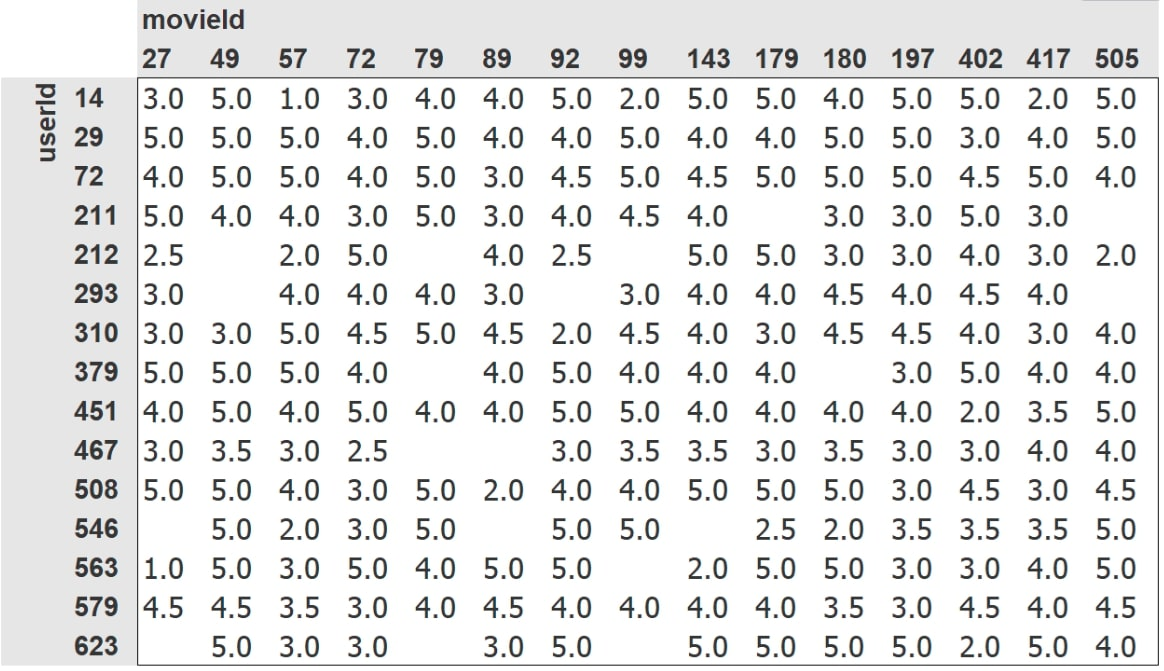

In [5]:
#The following picture shows the data in a more readable format

from IPython.display import Image

# Replace with your actual file path
Image(filename="/kaggle/input/picture/CL_fig.jpg", width=800)

# Latent Factors

The first step of this process involves **introducing the latent factors**, **a set of randomly initialized parameters**, for each user and movie, and can be selected as any arbitrary set of numbers (e.g., 5 for each user and movie). Next is to **calculate the predictions**, which can be determined simply as the **dot product of each movie with each user**. "If, for instance, the first latent user factor represents how much the user likes action movies and the first latent movie factor represents if the movie has a lot of action or not, the product of those will be particularly high if either the user likes action movies and the movie has a lot of action in it or the user doesn't like action movies and the movie doesn't have any action in it. On the other hand, if we have a mismatch (a user loves action movies but the movie isn't an action film, or the user doesn't like action movies and it is one), the product will be very low." Finally, to **calculate the loss**, using any loss function, like mean squared error. 

The **parameters (latent factors) can then be optimized** using stochastic gradient descent. "At each step, the stochastic gradient descent optimizer will calculate the match between each movie and each user using the dot product, and will compare it to the actual rating that each user gave to each movie. It will then calculate the derivative of this value and will step the weights by multiplying this by the learning rate. After doing this lots of times, the loss will get better and better, and the recommendations will also get better and better."

**Creating DataLoaders**

In [6]:
#Movie title may give a bit more perspective, so a dataframe is created and then merged with the earlier one.

movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [7]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


A DataLoaders object can be built from this table. By default, it takes the first column for the user, the second column for the item (here the movies), and the third column for the ratings. The value of item_name is changed to 'titles' instead of IDs.

In [14]:
#dls = CollabDataLoaders.from_df(ratings, bs=64) #Default

dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,145,"Cable Guy, The (1996)",1
1,474,"African Queen, The (1951)",4
2,929,Highlander (1986),1
3,178,Field of Dreams (1989),5
4,1,Die Hard (1988),4
5,291,Crash (1996),4
6,749,"Three Musketeers, The (1993)",3
7,642,Gone with the Wind (1939),5
8,391,Butch Cassidy and the Sundance Kid (1969),5
9,174,I.Q. (1994),4


In [15]:
#5 (random) latent factors are selected for each user and movie

n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

user_factors, movie_factors

(tensor([[ 1.2780,  0.6605,  0.6402, -0.1392,  0.1138],
         [-0.5257,  0.1581, -1.5192, -1.5879, -1.0350],
         [ 0.6259,  0.7240,  0.7253,  0.0993, -1.0900],
         ...,
         [-1.0954, -0.3547, -1.1953, -0.1785, -1.7022],
         [-0.3934,  0.9043,  0.0352,  0.8387, -0.3529],
         [-1.1398,  1.6870,  0.6779,  1.1276,  1.3463]]),
 tensor([[ 0.5887, -0.4192, -0.1918, -1.1089, -0.1026],
         [-0.6410, -0.4079,  0.4715, -2.6218, -0.9137],
         [-0.7951,  0.3349,  0.8642, -0.0728,  0.2955],
         ...,
         [-0.4506,  0.1650,  1.4848,  0.9989,  1.2573],
         [ 1.4176,  1.2897, -0.4175,  1.4425, -0.3909],
         [-1.6700, -0.7160,  0.7235, -1.2966,  0.8498]]))

To calculate the result for a particular movie and user combination, the index of the movie in the movie latent factor matrix and the index of the user in the user latent factor matrix need to be looked up, followed by determining the dot product. But looking up in an index is not an operation that deep learning models know how to do. They know how to do matrix products and activation functions.

However, it can represent look up in an index as a matrix product. The trick is to replace the indices with one-hot-encoded vectors. Here is an example of what happens if one multiplies a vector by a one-hot-encoded vector representing the index 3:

In [16]:
one_hot_3 = one_hot(3, n_users).float()

In [17]:
user_factors.t() @ one_hot_3

tensor([ 0.6982,  0.9460,  1.0220,  0.3163, -0.7171])

In [18]:
# Same vector as the one at index 3 in the matrix

user_factors[3]

tensor([ 0.6982,  0.9460,  1.0220,  0.3163, -0.7171])

"If we do that for a few indices at once, we will have a matrix of one-hot-encoded vectors, and that operation will be a matrix multiplication! This would be a perfectly acceptable way to build models using this kind of architecture, except that it would use a lot more memory and time than necessary. We know that there is no real underlying reason to store the one-hot-encoded vector, or to search through it to find the occurrence of the number one—we should just be able to index into an array directly with an integer. Therefore, most deep learning libraries, including PyTorch, include a special layer that does just this; it indexes into a vector using an integer, but has its derivative calculated in such a way that it is identical to what it would have been if it had done a matrix multiplication with a one-hot-encoded vector. This is called an embedding."

"**Embedding**: Multiplying by a one-hot-encoded matrix, using the computational shortcut that it can be implemented by simply indexing directly. This is quite a fancy word for a very simple concept. The thing that you multiply the one-hot-encoded matrix by (or, using the computational shortcut, index into directly) is called the embedding matrix."

# Collaborative Filtering from Scratch

**Basics of object-oriented programming and Python**: The key idea in object-oriented programming is the class, such as DataLoader, string, and Learner. Python also makes it easy to create new classes. Here is an example of a simple class:

In [19]:
class Example:
    def __init__(self, a): self.a = a
    def say(self,x): return f'Hello {self.a}, {x}.'

The most important piece of a class is the special method called __init__ (pronounced dunder init). In Python, any method surrounded by double underscores like this is considered special. It indicates that there is some extra behavior associated with this method name. In the case of __init__, this is the method Python will call when a new object is created. So, this is where one can set up any state that needs to be initialized upon object creation. Any parameters included when the user constructs an instance of your class will be passed to the __init__ method as parameters. Note that the **first parameter** to any method defined inside a class is **self**, so one can use this to set and get any attributes that they will need:

In [20]:
ex = Example('Sambit')
ex.say('nice to meet you')

'Hello Sambit, nice to meet you.'

Creating a new PyTorch module requires inheriting from Module. **Inheritance**, in very simplified term, means one can add additional behavior to an existing class. PyTorch already provides a Module class, which provides some basic foundations that is needed to built on. So, the following superclass is named after the name of the class that is being defined.

Further, in creating a new PyTorch module, PyTorch will call a method in the class called forward, and will pass along to that any parameters that are included in the call. Here is the class defining the dot product model:

In [21]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0]) # Lookup user embeddings (batch of user IDs)
        movies = self.movie_factors(x[:,1]) # Lookup movie embeddings (batch of movie IDs)
        return (users * movies).sum(dim=1) # Dot product for each user-movie pair

**DotProduct(Module)** Inherits from torch.nn.Module, the base class for all neural network modules in PyTorch and computes the dot product between user and movie embeddings to predict a rating

    def forward(self, x):
        users = self.user_factors(x[:,0]) 
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1) 

The input of the model is a tensor of shape batch_size x 2, where the first column (x[:, 0]) contains the user IDs and the second column (x[:, 1]) contains the movie IDs.

The following steps are involved

1. Lookup Embeddings:
users = self.user_factors(x[:, 0]): For each user ID in the batch, fetch its embedding vector (shape: (batch_size, n_factors)).
movies = self.movie_factors(x[:, 1]): Same for movies.

2. Element-wise Multiplication:

3. users * movies: Multiplies corresponding dimensions of the user and movie vectors and summing them up

In [22]:
# Fetching a single batch of data

x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

Mapping from Human-Readable Format to Raw Model Input

dls.show_batch() shows:
user=145, title="Cable Guy, The (1996)", rating=1.

dls.one_batch() shows:
x=tensor([0, 10]) (if user 145 is encoded as 0 and the movie as 10), y=tensor([1])

In [24]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.266413,1.316816,00:08
1,1.039896,1.118592,00:07
2,0.921916,0.997974,00:08
3,0.778523,0.914024,00:08
4,0.723182,0.889875,00:07


To make this model slightly better, those predictions can be forced between 0 and 5, using sigmoid_range. One thing discovered empirically is that it's better to have the range go a little bit over 5, so (0, 5.5) is used (since a sigmoid never reaches 1)

In [25]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [27]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.940013,0.999463,00:08
1,0.642554,0.949688,00:08
2,0.471200,0.949181,00:08
3,0.363519,0.951969,00:07
4,0.344507,0.950311,00:08


Another thing that can be introduced is the **biases**. For example, some users are just more positive or negative in their recommendations than others, and some movies are just plain better or worse than others. 

In [28]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [29]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.863321,0.949493,00:09
1,0.572121,0.916060,00:09
2,0.416570,0.944766,00:09
3,0.303090,0.952626,00:08
4,0.306830,0.954197,00:08


Instead of being better, it ends up being worse (at least at the end of training). Why is that? It can be noticed from both trainings that the validation loss stopped improving in the middle and started to get worse. This is a clear indication of overfitting. In this case, there is no way to use data augmentation, so another regularization technique is implemented, known as **weight decay**.

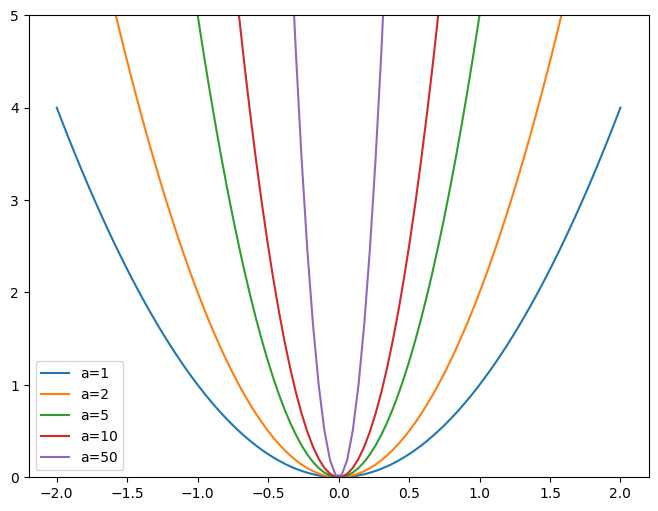

In [30]:
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

In [31]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.892426,0.965545,00:09
1,0.673105,0.901872,00:10
2,0.548210,0.878593,00:10
3,0.452056,0.861483,00:08
4,0.443676,0.857065,00:09
